In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

"""
评估数据集的构造
"""
df_5 = pd.read_csv('./data/附件5：门店交易验证数据.txt', sep='\t', parse_dates=[1], header=None, encoding='utf-8')   # 附件五
df_2 = pd.read_csv('../data/附件2：估价验证数据.txt', sep='\t', parse_dates=[1, 11, 12], header=None, encoding='utf-8')   # 附件二的信息

columns = ['carid', 'tradeTime', 'brand', 'serial', 'model', 'mileage', 'color', 'cityId', 'carCode',
           'transferCount', 'seatings', 'registerDate', 'licenseDate', 'country', 'maketype', 'modelyear',
           'displacement', 'gearbox', 'oiltype', 'newprice']
for i in range(1,16):
    columns.append('anonymousFeature'+str(i))
# 重命名数据列名
df_2.columns = columns
df_5.rename(columns={0:'carid',1:'pushDate',2:'pushPrice',3:'updatePriceTimeJson'} ,inplace=True)
# df_5.to_csv(r'D:\比赛\2021年MathorCup大数据竞赛赛道A\复赛\附件五.csv', encoding='utf-8')
df_test = pd.merge(df_5, df_2, on='carid', how='left')
# df_test.to_csv(r'D:\比赛\2021年MathorCup大数据竞赛赛道A\复赛\任务一test.csv')
"""
训练集的构造
"""
df_1 = pd.read_csv('../data/附件1：估价训练数据.txt', sep='\t', parse_dates=[1, 11, 12], encoding='utf-8', header=None)  # 附件一
df_4 = pd.read_csv('../data/附件4：门店交易训练数据.txt', sep='\t', parse_dates=[1, 4, 5], encoding='utf-8', header=None)   # 附件四

columns.append('price')
df_1.columns=columns
df_4.rename(columns={0:'carid',1:'pushDate',2:'pushPrice',3:'updatePriceTimeJson',4:'pullDate',5:'withdrawDate'},inplace=True)
df_train = pd.merge(df_4, df_1, how='left', on='carid')

# print(df_train.columns)
# print(df_test.columns)

# 调整trian的数据特征，保持与test一致

df_train['cycle'] = df_train['withdrawDate']-df_train['pushDate']
df_train=df_train.drop(['price', 'pullDate', 'withdrawDate'], axis=1)
df_train['cycle']=df_train['cycle'].astype('timedelta64[D]')
# df_train.to_csv(r'D:\比赛\2021年MathorCup大数据竞赛赛道A\复赛\任务一train.csv')





In [14]:
from sklearn.model_selection import GridSearchCV

In [2]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   carid                10000 non-null  int64          
 1   pushDate             10000 non-null  datetime64[ns] 
 2   pushPrice            10000 non-null  float64        
 3   updatePriceTimeJson  10000 non-null  object         
 4   tradeTime            10000 non-null  datetime64[ns] 
 5   brand                10000 non-null  int64          
 6   serial               10000 non-null  int64          
 7   model                10000 non-null  int64          
 8   mileage              10000 non-null  float64        
 9   color                10000 non-null  int64          
 10  cityId               10000 non-null  int64          
 11  carCode              9994 non-null   float64        
 12  transferCount        10000 non-null  int64          
 13  seatings         

In [3]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   carid                2000 non-null   int64         
 1   pushDate             2000 non-null   datetime64[ns]
 2   pushPrice            2000 non-null   float64       
 3   updatePriceTimeJson  2000 non-null   object        
 4   tradeTime            2000 non-null   datetime64[ns]
 5   brand                2000 non-null   int64         
 6   serial               2000 non-null   int64         
 7   model                2000 non-null   int64         
 8   mileage              2000 non-null   float64       
 9   color                2000 non-null   int64         
 10  cityId               2000 non-null   int64         
 11  carCode              2000 non-null   int64         
 12  transferCount        2000 non-null   int64         
 13  seatings             2000 non-nul

In [4]:
df_train.isnull().sum()

carid                     0
pushDate                  0
pushPrice                 0
updatePriceTimeJson       0
tradeTime                 0
brand                     0
serial                    0
model                     0
mileage                   0
color                     0
cityId                    0
carCode                   6
transferCount             0
seatings                  0
registerDate              0
licenseDate               0
country                1384
maketype               1345
modelyear                96
displacement              0
gearbox                   1
oiltype                   0
newprice                  0
anonymousFeature1       505
anonymousFeature2         0
anonymousFeature3         0
anonymousFeature4      3908
anonymousFeature5         0
anonymousFeature6         0
anonymousFeature7      6617
anonymousFeature8      1395
anonymousFeature9      1378
anonymousFeature10     2172
anonymousFeature11      176
anonymousFeature12        0
anonymousFeature13  

In [5]:
df_test.isnull().sum()

carid                     0
pushDate                  0
pushPrice                 0
updatePriceTimeJson       0
tradeTime                 0
brand                     0
serial                    0
model                     0
mileage                   0
color                     0
cityId                    0
carCode                   0
transferCount             0
seatings                  0
registerDate              0
licenseDate               0
country                 196
maketype                186
modelyear                41
displacement              0
gearbox                   0
oiltype                   0
newprice                  0
anonymousFeature1       138
anonymousFeature2         0
anonymousFeature3         0
anonymousFeature4       705
anonymousFeature5         0
anonymousFeature6         0
anonymousFeature7      1459
anonymousFeature8       203
anonymousFeature9       202
anonymousFeature10      501
anonymousFeature11       40
anonymousFeature12        0
anonymousFeature13  

In [6]:
# df_train['cycle']= df_train['cycle'].astype(int)
# df_train['cycle']

In [7]:
# df_train['cycle'].fillna(pd.Timedelta(seconds=0))

In [8]:
# df_train['cycle']=
type(df_train['cycle'].astype('timedelta64[D]')[0])
df_train['cycle']=df_train['cycle'].astype('timedelta64[D]')

In [9]:
df_train['cycle']

0        0.0
1       31.0
2       26.0
3        3.0
4       53.0
        ... 
9995     NaN
9996     NaN
9997     NaN
9998     NaN
9999     NaN
Name: cycle, Length: 10000, dtype: float64

In [10]:
df_train=df_train.dropna(subset=['cycle'])
df_train.loc[df_train['country']==0,'country']=779410

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

<AxesSubplot:>

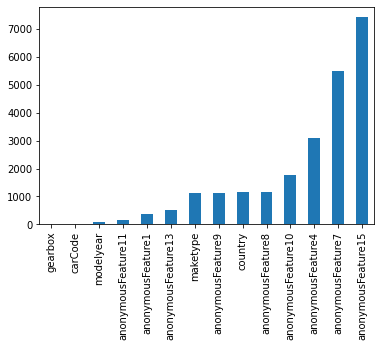

In [12]:
missing=df_train.isnull().sum()
missing=missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar()

<AxesSubplot:>

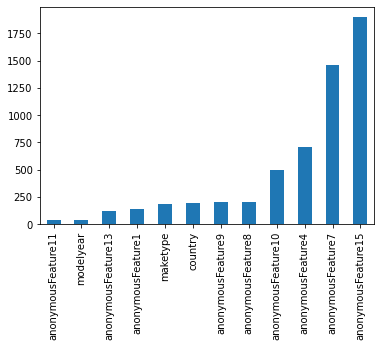

In [13]:
missing=df_test.isnull().sum()
missing=missing[missing>0]
missing.sort_values(inplace=True)
missing.plot.bar()

<AxesSubplot:>

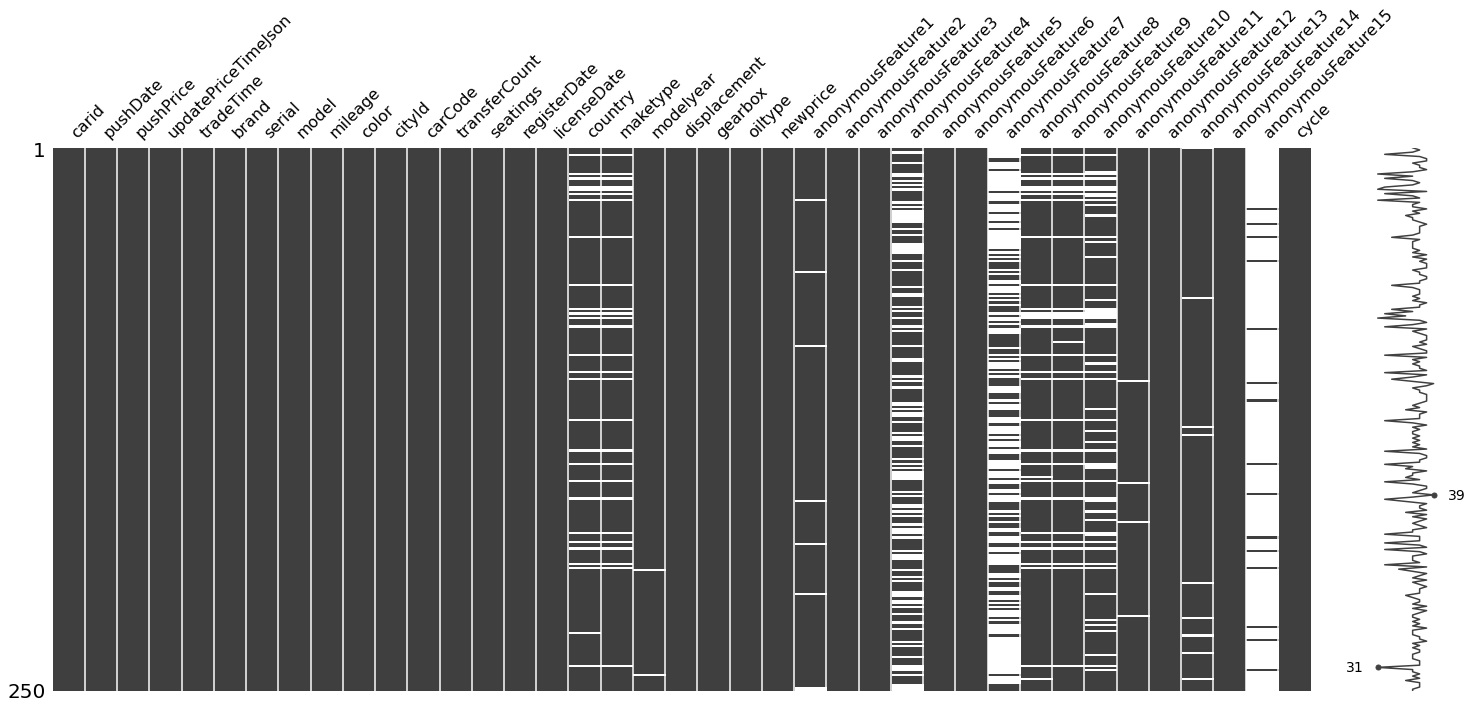

In [14]:
msno.matrix(df_train.sample(250))

<AxesSubplot:>

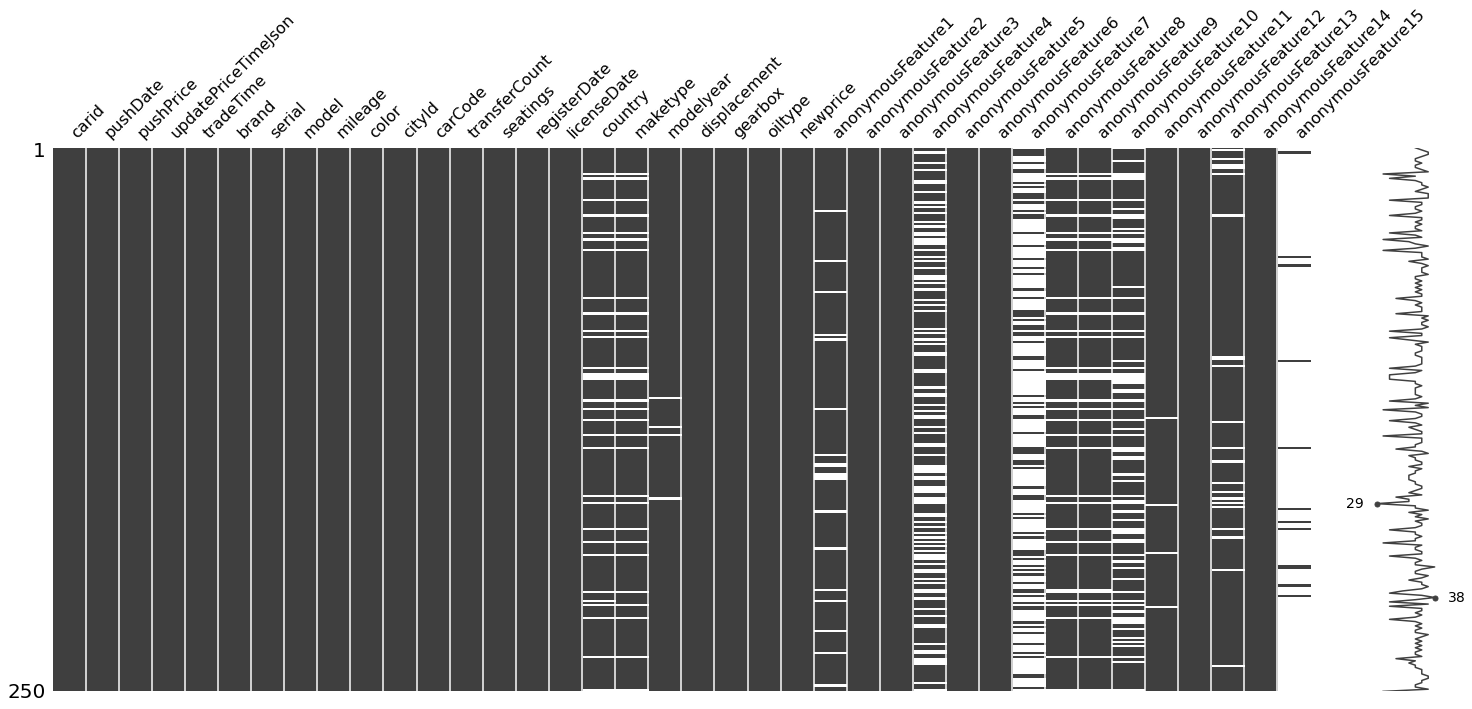

In [15]:
msno.matrix(df_test.sample(250))

<AxesSubplot:>

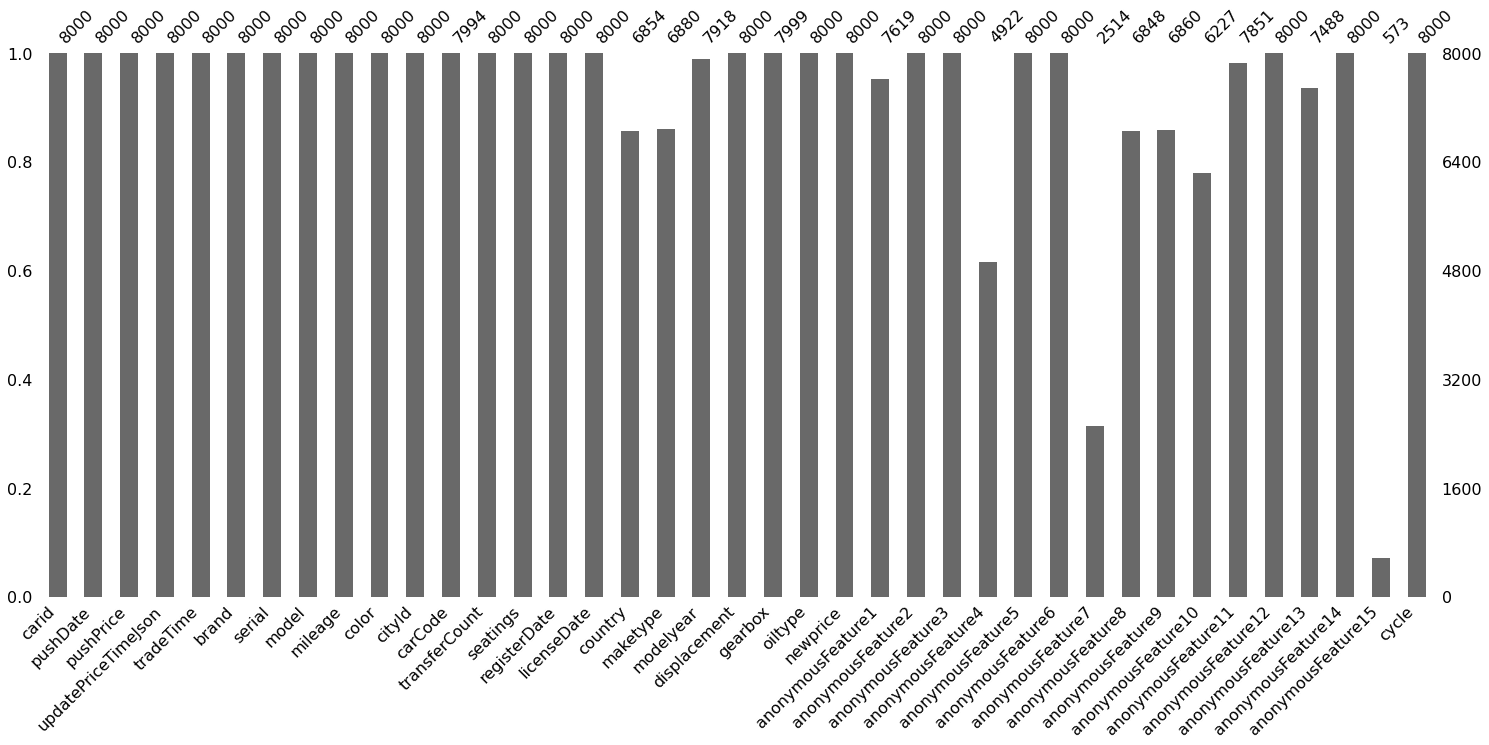

In [16]:
msno.bar(df_train)

<AxesSubplot:>

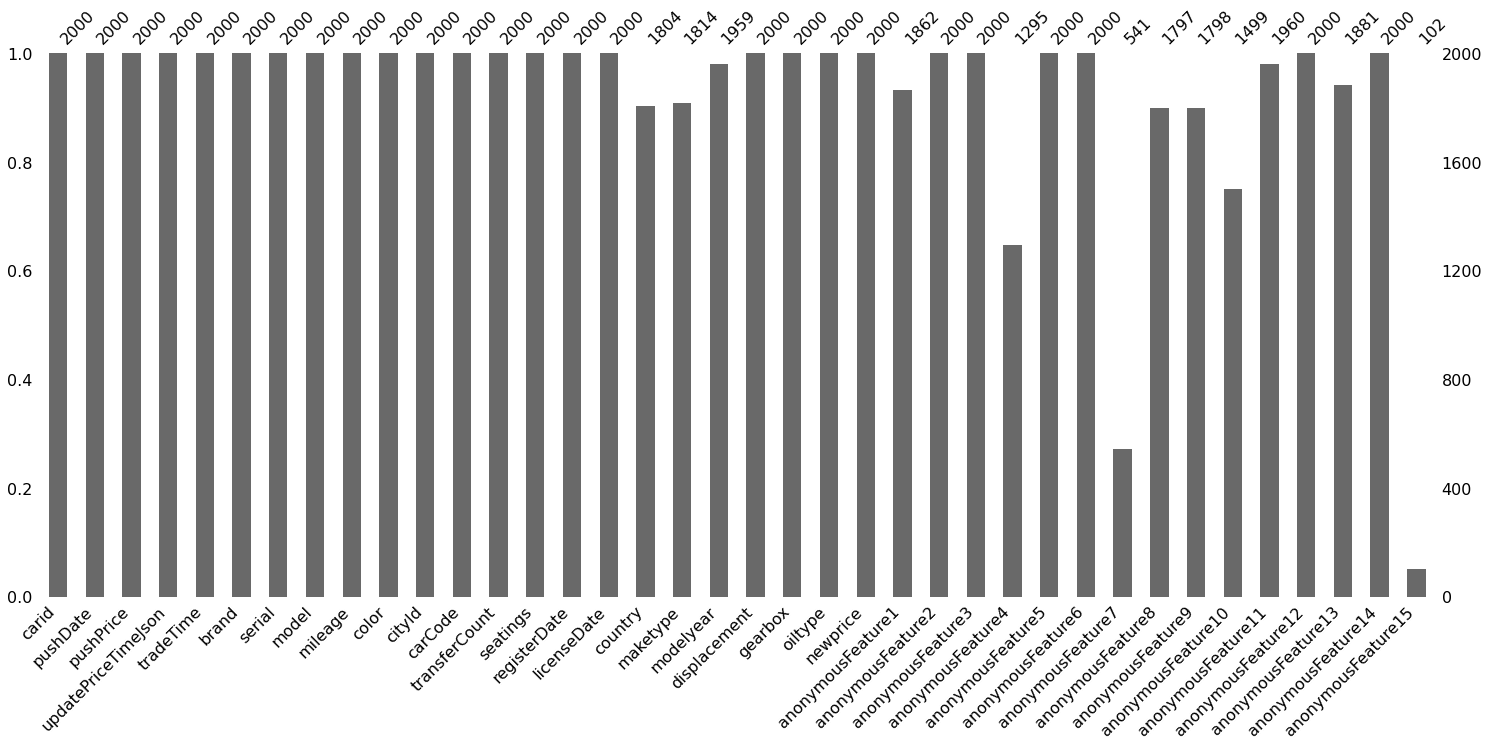

In [17]:
msno.bar(df_test)

删除nan存在的过多的特征，其余缺失值较少的使用lgb树模型可以直接空缺，让树自己去优化

发现anonymousFeature1的严重倾斜，一般不会对预测有什么帮助，故这边先删掉

<AxesSubplot:ylabel='anonymousFeature1'>

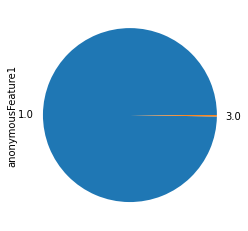

In [18]:
df_train['anonymousFeature1'].value_counts(normalize=True).plot(kind='pie')

In [19]:
df_train['anonymousFeature1'].value_counts(normalize=True)

1.0    0.997375
3.0    0.002625
Name: anonymousFeature1, dtype: float64

In [20]:
df_test['anonymousFeature1'].value_counts(normalize=True)

1.0    0.997315
3.0    0.002148
4.0    0.000537
Name: anonymousFeature1, dtype: float64

看一下预测值的分布

In [21]:
df_train['cycle']

0         0.0
1        31.0
2        26.0
3         3.0
4        53.0
        ...  
7995     13.0
7996    218.0
7997     10.0
7998      4.0
7999      1.0
Name: cycle, Length: 8000, dtype: float64

In [22]:
df_train['cycle'].value_counts()

1.0      451
3.0      366
2.0      359
4.0      344
5.0      341
        ... 
227.0      1
179.0      1
263.0      1
168.0      1
146.0      1
Name: cycle, Length: 186, dtype: int64

cycle的整体分布情况

d:\python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
d:\python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
d:\python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(

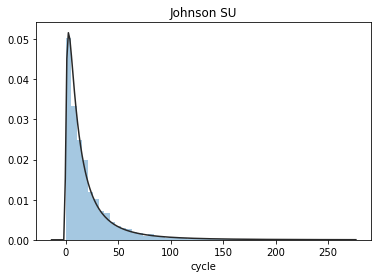

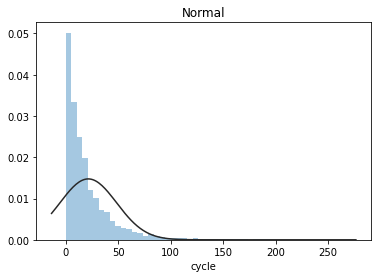

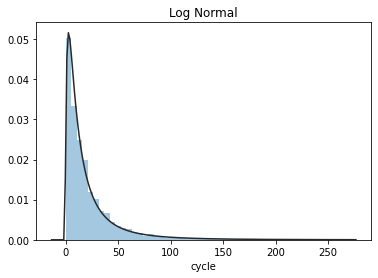

In [23]:
import scipy.stats as st
y = df_train['cycle']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)
plt.savefig('13.jpg')

.........

cycle不服从正态分布，所以在进行回归之前，它必须进行转换。显然对数变换做得很好

d:\python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 3.139473
Kurtosis: 14.291402


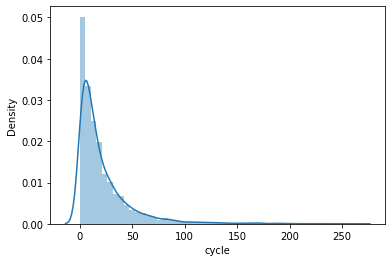

In [24]:
# 查看skewness and kurtosis
sns.distplot(df_train['cycle']);
print("Skewness: %f" % df_train['cycle'].skew())
print("Kurtosis: %f" % df_train['cycle'].kurt())

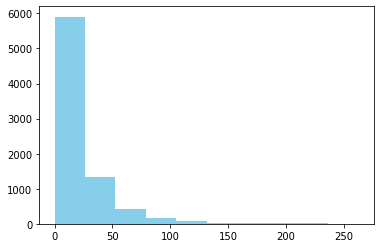

In [25]:
# 查看预测值的频次分布
plt.hist(df_train['cycle'], orientation = 'vertical',histtype = 'bar', color ='skyblue')
plt.show()

In [26]:
df_train['cycle']

0         0.0
1        31.0
2        26.0
3         3.0
4        53.0
        ...  
7995     13.0
7996    218.0
7997     10.0
7998      4.0
7999      1.0
Name: cycle, Length: 8000, dtype: float64

cycle数据中有0，因此无法画图

In [27]:
# df_train['cycle'].value_counts()[0.0]
data=df_train[df_train['cycle']!=0.0]
data['cycle']

1        31.0
2        26.0
3         3.0
4        53.0
5        49.0
        ...  
7995     13.0
7996    218.0
7997     10.0
7998      4.0
7999      1.0
Name: cycle, Length: 7750, dtype: float64

In [28]:
data['cycle'].unique()


array([ 31.,  26.,   3.,  53.,  49.,  25.,  52.,   9.,  14.,   6., 117.,
        13.,  15.,   2.,   8.,  41.,  12.,   4.,  57.,  42.,  84.,   1.,
        54.,   5.,   7.,  27.,  24.,  45., 112.,  19.,  38.,  10.,  23.,
        47.,  11., 137.,  83.,  17.,  69.,  16.,  18.,  44.,  51.,  29.,
        60.,  36.,  33.,  71.,  88.,  21., 104.,  46.,  37.,  20.,  56.,
        62.,  22.,  66.,  39.,  92.,  34.,  64.,  86.,  30.,  80.,  35.,
        98.,  67.,  32.,  73.,  55.,  58., 109.,  28.,  72.,  50., 110.,
        77.,  93., 228., 127., 102.,  76.,  65.,  61., 136.,  43.,  91.,
        40.,  48.,  87., 263., 107.,  89., 166., 174.,  90., 126.,  59.,
        63., 119., 190., 237.,  68.,  85., 171., 111., 115., 244., 170.,
       135., 192., 139., 145., 151.,  94.,  79., 150., 172.,  99., 105.,
       108., 235., 169., 128., 130.,  70., 155.,  74., 123., 138., 154.,
       133., 142.,  75., 122., 184., 201.,  82., 106., 116., 129.,  81.,
       212., 191., 101.,  97., 197., 118., 167.,  7

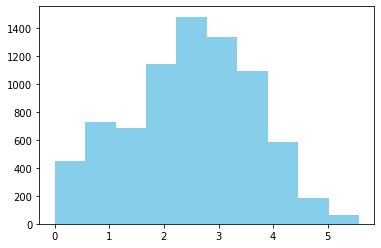

In [29]:
plt.hist(np.log(data['cycle']), orientation = 'vertical',histtype = 'bar', color ='skyblue') 
plt.show()

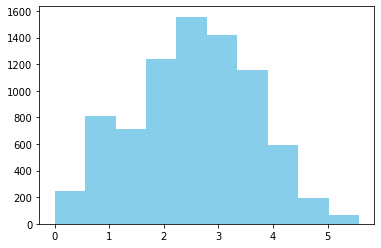

In [30]:
# log变换 z之后的分布较均匀，可以进行log变换进行预测，这也是预测问题常用的trick
plt.hist(np.log(df_train['cycle'].values+1), orientation = 'vertical',histtype = 'bar', color ='skyblue') 
plt.show()

In [123]:
np.log([1, np.e, np.e**2, 0])

d:\python\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


array([  0.,   1.,   2., -inf])

In [124]:
import pandas_profiling
pfr = pandas_profiling.ProfileReport(df_train)
pfr.to_file("./example.html")

ModuleNotFoundError: No module named 'pandas_profiling'

In [31]:
feature_num=['mileage','transferCount','seatings','displacement','gearbox','newprice','pushPrice','cycle']
feature_class=['brand','serial','model','color','cityId','carCode','country','maketype','modelyear','oiltype']


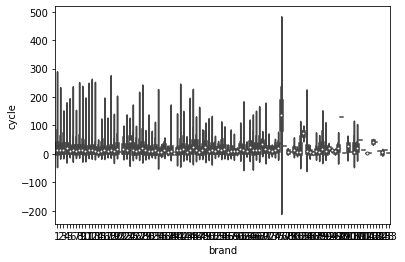

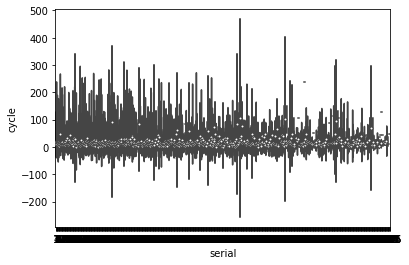

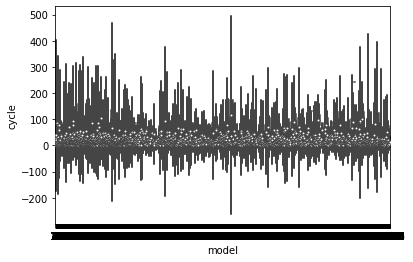

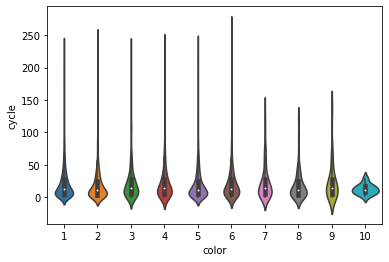

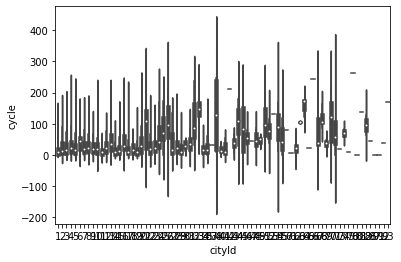

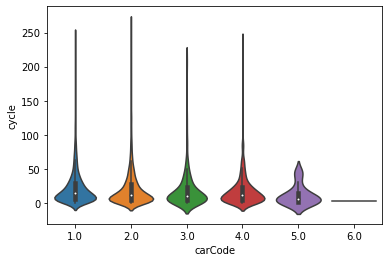

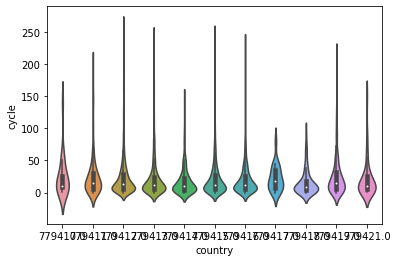

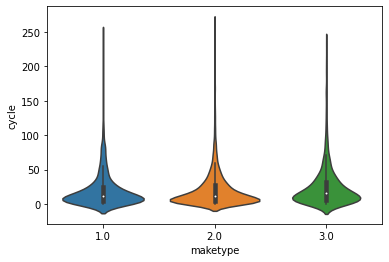

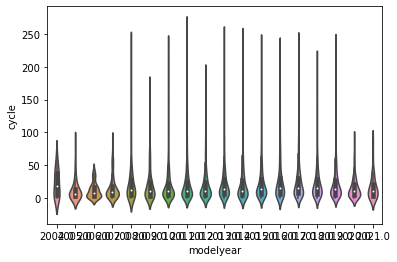

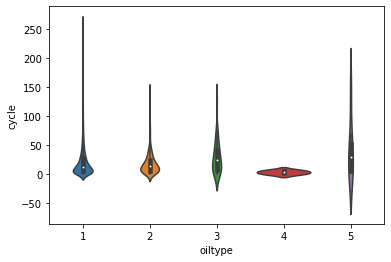

In [126]:
class_list = feature_class
for cla in class_list :
    sns.violinplot(x=cla, y='cycle', data=df_train)
    plt.show()

In [137]:
df_train['cycle'].unique()

array([  0.,  31.,  26.,   3.,  53.,  49.,  25.,  52.,   9.,  14.,   6.,
       117.,  13.,  15.,   2.,   8.,  41.,  12.,   4.,  57.,  42.,  84.,
         1.,  54.,   5.,   7.,  27.,  24.,  45., 112.,  19.,  38.,  10.,
        23.,  47.,  11., 137.,  83.,  17.,  69.,  16.,  18.,  44.,  51.,
        29.,  60.,  36.,  33.,  71.,  88.,  21., 104.,  46.,  37.,  20.,
        56.,  62.,  22.,  66.,  39.,  92.,  34.,  64.,  86.,  30.,  80.,
        35.,  98.,  67.,  32.,  73.,  55.,  58., 109.,  28.,  72.,  50.,
       110.,  77.,  93., 228., 127., 102.,  76.,  65.,  61., 136.,  43.,
        91.,  40.,  48.,  87., 263., 107.,  89., 166., 174.,  90., 126.,
        59.,  63., 119., 190., 237.,  68.,  85., 171., 111., 115., 244.,
       170., 135., 192., 139., 145., 151.,  94.,  79., 150., 172.,  99.,
       105., 108., 235., 169., 128., 130.,  70., 155.,  74., 123., 138.,
       154., 133., 142.,  75., 122., 184., 201.,  82., 106., 116., 129.,
        81., 212., 191., 101.,  97., 197., 118., 16

In [127]:
df_train['country'].unique()

array([779414., 779413., 779412., 779415., 779411., 779416., 779419.,
           nan, 779421., 779418., 779410., 779417.])

In [135]:
data_1=df_train[feature_num]
pearson=data_1.corr()
pearson['cycle'].abs().sort_values(ascending=False)

cycle            1.000000
transferCount    0.104020
pushPrice        0.069369
mileage          0.028779
seatings         0.027058
newprice         0.024577
displacement     0.011198
gearbox          0.003984
Name: cycle, dtype: float64

<AxesSubplot:>

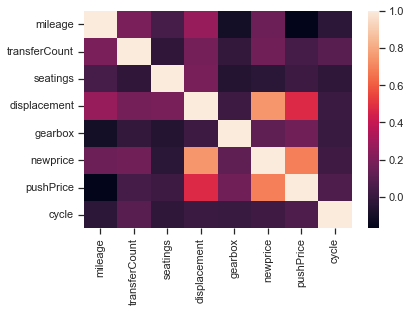

In [136]:
sns.set(style='ticks')
sns.heatmap(pearson)

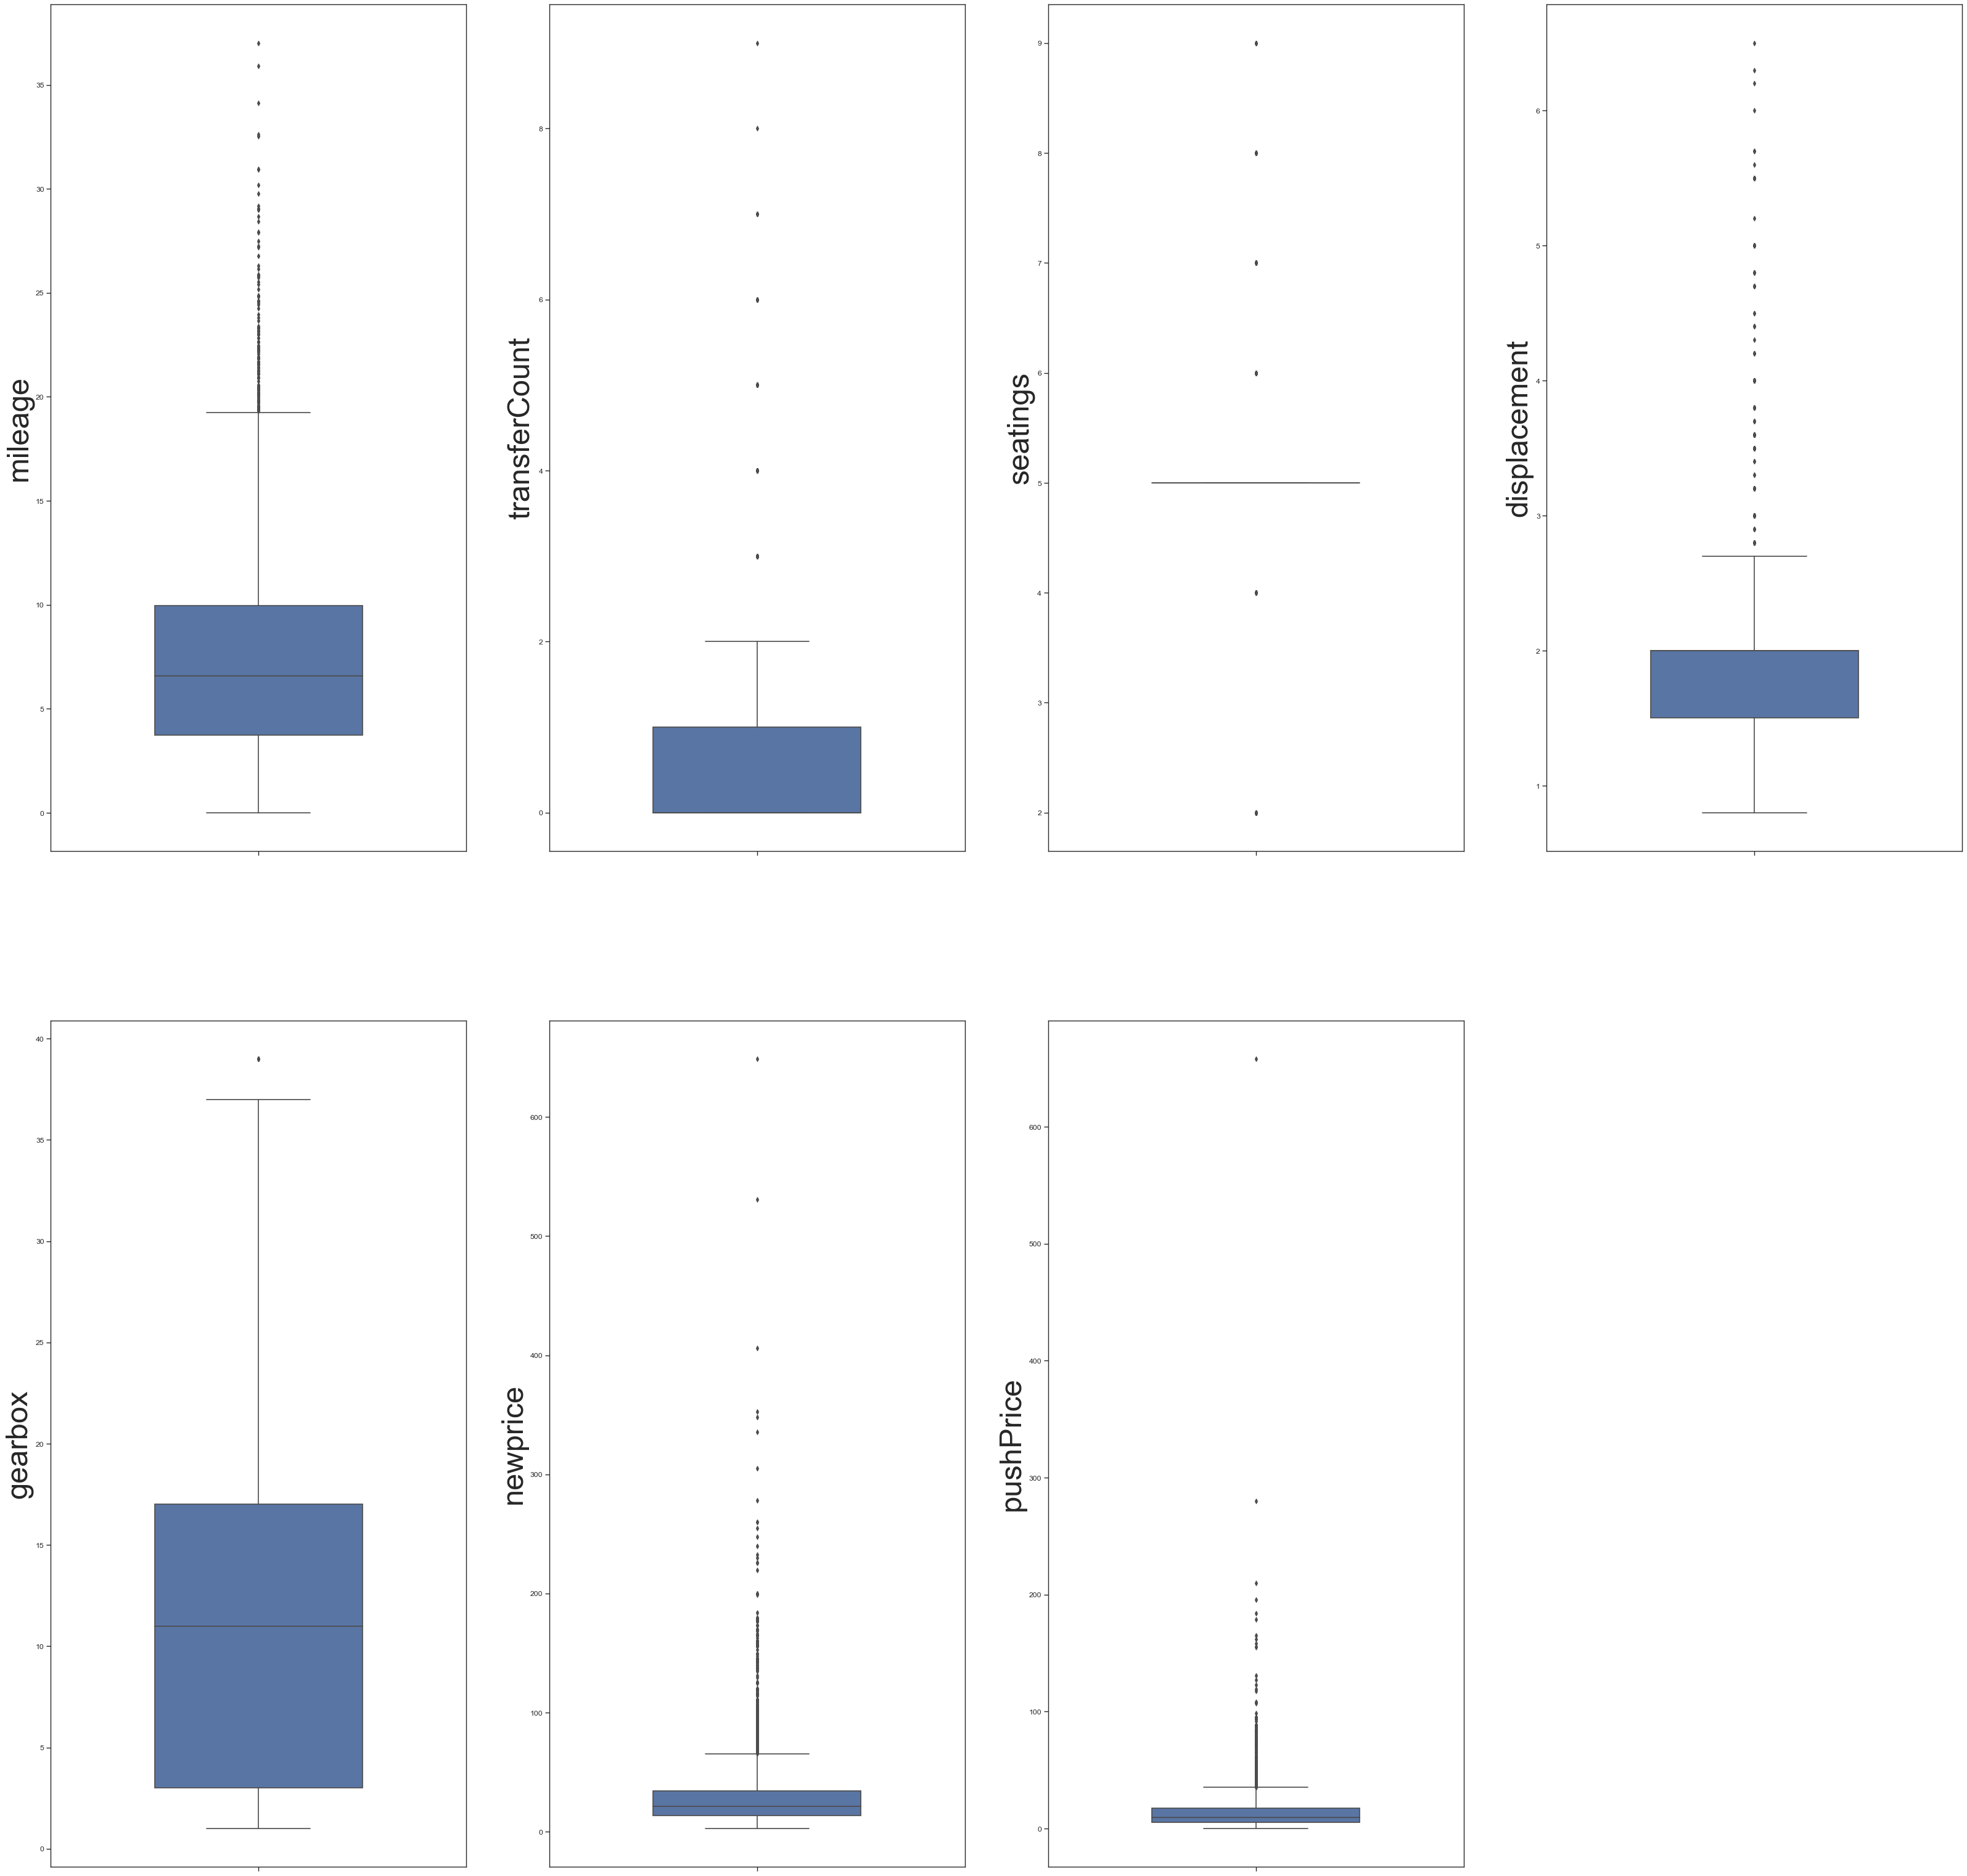

In [141]:
# 查看数值型的是否存在异常值
nn=['mileage','transferCount','seatings','displacement','gearbox','newprice','pushPrice']
fig=plt.figure(figsize=(50,50),dpi=80)
for i in range(7):
    ax=plt.subplot(2,4,i+1)
    ax=sns.boxplot(y=df_train[nn[i]],orient='v',width=0.5)
    plt.ylabel(nn[i],fontsize=44)
plt.savefig('4.png')
plt.show()

In [142]:
def replace(x):
    QU = x.quantile(0.75)
    QL = x.quantile(0.25)
    IQR = QU -QL
    x[(x>(QU+1.5*IQR)) | (x<(QL - 1.5*IQR))] = np.nan
    return x


In [143]:
for i in nn:
    df_train[i]=replace(df_train[i])


d:\python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
d:\python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
d:\python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
d:\python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [32]:
bin = [i*5 for i in range(9)]
bin.append(660)
df_train['pushPrice_bin'] = pd.cut(df_train['pushPrice'], bin, labels=False)
df_train[['pushPrice_bin', 'pushPrice']].head()

,pushPrice_bin,pushPrice
0,0,3.9800
1,0,4.5000
2,4,23.9000
3,4,20.5798
4,2,12.2800


开始建模

In [10]:
df_train=df_train.dropna(subset=['cycle'])
df_train.loc[df_train['country']==0,'country']=779410
# df_train['country'].unique()



# feature_num=['mileage','transferCount','seatings','displacement','gearbox','newprice','cycle']
# feature_class=['brand','serial','model','color','cityId','carCode','country','maketype','modelyear','oiltype']
# 数值型的相关系数
# data_1=df_train[feature_num]
# pearson=data_1.corr()
# pearson['cycle'].abs().sort_values(ascending=False)
# pearson.index.to_list()


# df_train.dropna(how='any',subset=['carCode','gearbox'],inplace=True)  # 训练集中有缺失值，缺失值较少 ：6个，1个

def fill_(data):
    n=['country','maketype','modelyear']
    for i in n:
        x=int(data[i].mode())
        data[i].fillna(x,inplace=True)
    return data
df_train=fill_(df_train)
df_test=fill_(df_test)

df_train.drop(['anonymousFeature4','anonymousFeature7','anonymousFeature15'],axis=1,inplace=True)
df_test.drop(['anonymousFeature4','anonymousFeature7','anonymousFeature15'],axis=1,inplace=True)
"""
异常值检验
"""
df_train.isnull().sum()

def replace(x):
    QU = x.quantile(0.75)
    QL = x.quantile(0.25)
    IQR = QU -QL
    x[(x>(QU+1.5*IQR)) | (x<(QL - 1.5*IQR))] = np.nan
    return x


nn=['mileage','transferCount','seatings','displacement','gearbox','newprice','pushPrice']
for i in nn:
    df_train[i] = replace(df_train[i])
"""
特征工程
"""
def deal_time(df_train):
    df_train['old_year']=df_train['tradeTime']-df_train['registerDate']
    df_train['old_year']=df_train['old_year'].apply(lambda x:str(x).split(' ')[0])
    df_train['old_year']=df_train['old_year'].astype(int)

    df_train['old_year_1']=df_train['tradeTime']-df_train['licenseDate']
    df_train['old_year_1']=df_train['old_year_1'].apply(lambda x:str(x).split(' ')[0])
    df_train['old_year_1']=df_train['old_year_1'].astype(int)
    return df_train

df_train=deal_time(df_train)
df_test=deal_time(df_test)

def f(x):
    if re.findall(': ".+?"',str(x)):
        res=re.findall(': ".+?"',str(x))[-1]
        a=res.replace('"','').replace(':','').replace(' ','')
        a=float(a)
    else:
        a=0.0
    return a

# res=re.findall(': ".+?"','{"2020-12-29": "17.68", "2020-12-30": "17.8799", "2021-01-15": "16.8799"}')
# a=res[-1].replace('"','').replace(':','').replace(' ','')
# a=float(a)
# res=re.findall(': ".+?"','{}')[-1]
"""
求出最终的价格
"""

df_train['last_updatePrice']=df_train['updatePriceTimeJson'].map(f)
df_train.loc[df_train['last_updatePrice']==0.0000,'last_updatePrice']=df_train.loc[df_train['last_updatePrice']==0.0000,'pushPrice']

df_test['last_updatePrice']=df_test['updatePriceTimeJson'].map(f)
df_test.loc[df_test['last_updatePrice']==0.0000,'last_updatePrice']=df_test.loc[df_test['last_updatePrice']==0.0000,'pushPrice']

"""
构造特征
"""
def deal_ano_feature(df_train):
    df_train['anonymousFeature11'].fillna('1+2',inplace=True)
    def deal_11(x):
        return sum([float(x) for x in re.findall("\d",x)])
    df_train['anonymousFeature11']=df_train['anonymousFeature11'].map(deal_11)

    # 处理匿名特征12
    def deal_12(x):
        li=[float(x) for x in re.findall("\d+",x)]
        return li[0]*li[1]*li[2]
    df_train['anonymousFeature12_length']=df_train['anonymousFeature12'].apply(lambda x:int(x.split('*')[0]))
    df_train['anonymousFeature12_width']=df_train['anonymousFeature12'].apply(lambda x:int(x.split('*')[1]))
    df_train['anonymousFeature12_height']=df_train['anonymousFeature12'].apply(lambda x:int(x.split('*')[2]))
    df_train['anonymousFeature12']=df_train['anonymousFeature12'].map(deal_12)
    # 处理匿名特征13
    df_train['anonymousFeature13'].fillna(int(df_train['anonymousFeature13'].mode()),inplace=True)
    def deal_13(x):
        return x[:4], x[4:6]
    df_train['anonymousFeature13']=df_train['anonymousFeature13'].astype('string')
    df_train['anonymousFeature13_year']=df_train['anonymousFeature13'].map(deal_13)    #  (2017, 09)
    df_train['anonymousFeature13_month']=df_train['anonymousFeature13_year'].apply(lambda x: int(x[1]))
    df_train['anonymousFeature13_year']=df_train['anonymousFeature13_year'].apply(lambda x: int(x[0]))
    df_train['anonymousFeature13']=df_train['anonymousFeature13'].astype('float')

    df_train.isnull().sum()

    # df_train.dtypes

    def deal(data=None):
        li=[]
        for i in data.index:
            count=len(re.findall('\d+-\d+-\d+',str(data.loc[i,'updatePriceTimeJson'])))
            li.append(count)
        return li

    df_train['decreasing_count']=deal(df_train)

    """
    对剩余的缺失值进行填充
    """
    # 匿名变量1 , 8 ,9 ,10先用众数填充；   或者删除有缺失值的行
    def fill_v(data):
        n=['anonymousFeature1','anonymousFeature8','anonymousFeature9','anonymousFeature10']
        for i in n:
            x=int(data[i].mode())
            data[i].fillna(x,inplace=True)
        return data

    # df_train=fill_v(df_train)
    df_train['pushDate_year'] = df_train['pushDate'].dt.year
    df_train['pushDate_month'] = df_train['pushDate'].dt.month
    df_train['pushDate_day'] = df_train['pushDate'].dt.day
    return df_train

df_train=deal_ano_feature(df_train)
df_test=deal_ano_feature(df_test)
# 将cycle调整到最后一列

# 数据分箱
bin = [i*5 for i in range(9)]

df_train['pushPrice_bin'] = pd.cut(df_train['pushPrice'], bin, labels=False)

df_test['pushPrice_bin'] = pd.cut(df_test['pushPrice'], bin, labels=False)


df_train=df_train.select_dtypes(include=['int64','float64','int32'])
df_test=df_test.select_dtypes(include=['int64','float64','int32'])

In [11]:
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=150, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) 
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=127,n_estimators = 150)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm

In [12]:
cycle=df_train['cycle']
df_train=df_train.drop('cycle',axis=1)
df_train['cycle']=cycle

df_train['seatings'].unique()
df_train=df_train.drop('seatings',axis=1)

pearson=df_train.corr()
index = pearson['cycle'][:-1].abs() > 0.03
X_submit=df_train.iloc[:,:-1]
X_submit=X_submit.loc[:,index]
features=X_submit.columns

y=np.log1p(df_train['cycle'])

X_train,X_test,y_train,y_test=train_test_split(X_submit.iloc[:,:],y,test_size=0.3)


clf=lgb.LGBMRegressor(
    learning_rate=0.01,
    max_depth=-1,
    n_estimators=5000,
    boosting_type='gbdt',
    random_state=2022,
    objective='regression',
)

clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
y_pred=np.expm1(y_pred)

X_=df_test[features]

In [23]:
print('Train lgb...')
model_lgb = build_model_lgb(X_train,y_train)
val_lgb = model_lgb.predict(X_test)
val_lgb=np.expm1(val_lgb)
MAE_lgb = mean_absolute_error(y_test,val_lgb)
print('MAE of val with lgb:',MAE_lgb)

print('Predict lgb...')
model_lgb_pre = build_model_lgb(X_submit,y)     # 用上所有的训练集
subA_lgb = model_lgb_pre.predict(X_)
subA_lgb=np.expm1(subA_lgb)

Train lgb...
MAE of val with lgb: 10.583323985896877
Predict lgb...


In [24]:
print('Train xgb...')
model_xgb = build_model_xgb(X_train,y_train)
val_xgb = model_xgb.predict(X_test)
val_xgb=np.expm1(val_xgb)
MAE_xgb = mean_absolute_error(y_test,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

print('Predict xgb...')
model_xgb_pre = build_model_xgb(X_submit,y)
subA_xgb = model_xgb_pre.predict(X_)
subA_xgb=np.expm1(subA_xgb)

Train xgb...
MAE of val with xgb: 12.141220335275063
Predict xgb...


In [25]:
sub_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*subA_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*subA_xgb


In [26]:
res = pd.DataFrame()
res['carid'] = df_test.carid
res['cycle'] = sub_Weighted
res.to_csv('./附件6：门店交易模型结果.txt',sep='\t',index=False,header=None)

In [23]:
def fill_(data):
    n=['country','maketype','modelyear']
    for i in n:
        x=int(data[i].mode())
        data[i].fillna(x,inplace=True)
    return data
df_train=fill_(df_train)
df_test=fill_(df_test)
# print(df_test.isnull().sum())
# print(df_train.isnull().sum())

In [24]:
df_train.drop(['anonymousFeature4','anonymousFeature7','anonymousFeature15'],axis=1,inplace=True)
df_test.drop(['anonymousFeature4','anonymousFeature7','anonymousFeature15'],axis=1,inplace=True)

In [25]:
df_train.dtypes

carid                           int64
pushDate               datetime64[ns]
pushPrice                     float64
updatePriceTimeJson            object
tradeTime              datetime64[ns]
brand                           int64
serial                          int64
model                           int64
mileage                       float64
color                           int64
cityId                          int64
carCode                       float64
transferCount                   int64
seatings                        int64
registerDate           datetime64[ns]
licenseDate            datetime64[ns]
country                       float64
maketype                      float64
modelyear                     float64
displacement                  float64
gearbox                       float64
oiltype                         int64
newprice                      float64
anonymousFeature1             float64
anonymousFeature2               int64
anonymousFeature3               int64
anonymousFea

In [33]:
import re
df_train['anonymousFeature11'].fillna('1+2',inplace=True)
def deal_11(x):
    return sum([float(x) for x in re.findall("\d",x)])
df_train['anonymousFeature11']=df_train['anonymousFeature11'].map(deal_11)

# 处理匿名特征12
def deal_12(x):
    li=[float(x) for x in re.findall("\d+",x)]
    return li[0]*li[1]*li[2]
df_train['anonymousFeature12_length']=df_train['anonymousFeature12'].apply(lambda x:int(x.split('*')[0]))
df_train['anonymousFeature12_width']=df_train['anonymousFeature12'].apply(lambda x:int(x.split('*')[1]))
df_train['anonymousFeature12_height']=df_train['anonymousFeature12'].apply(lambda x:int(x.split('*')[2]))
df_train['anonymousFeature12']=df_train['anonymousFeature12'].map(deal_12)
# 处理匿名特征13
df_train['anonymousFeature13'].fillna(int(df_train['anonymousFeature13'].mode()),inplace=True)
def deal_13(x):
    return x[:4], x[4:6]
df_train['anonymousFeature13']=df_train['anonymousFeature13'].astype('string')
df_train['anonymousFeature13_year']=df_train['anonymousFeature13'].map(deal_13)    #  (2017, 09)
df_train['anonymousFeature13_month']=df_train['anonymousFeature13_year'].apply(lambda x: int(x[1]))
df_train['anonymousFeature13_year']=df_train['anonymousFeature13_year'].apply(lambda x: int(x[0]))
df_train['anonymousFeature13']=df_train['anonymousFeature13'].astype('float')

In [31]:
# fig = plt.figure(figsize=(80,60),dpi=76)
# sns.boxplot(df_train['pushDate'],orient='v',widths=0.5)
# plt.ylabel('pushDate')

['anonymousFeature1', 'anonymousFeature2', 'anonymousFeature3', 'anonymousFeature4', 'anonymousFeature5', 'anonymousFeature6', 'anonymousFeature7', 'anonymousFeature8', 'anonymousFeature9', 'anonymousFeature10', 'anonymousFeature11', 'anonymousFeature12', 'anonymousFeature13', 'anonymousFeature14']


d:\python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
d:\python\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
d:\python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
d:\python\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
d:\python\lib\site-packages\se

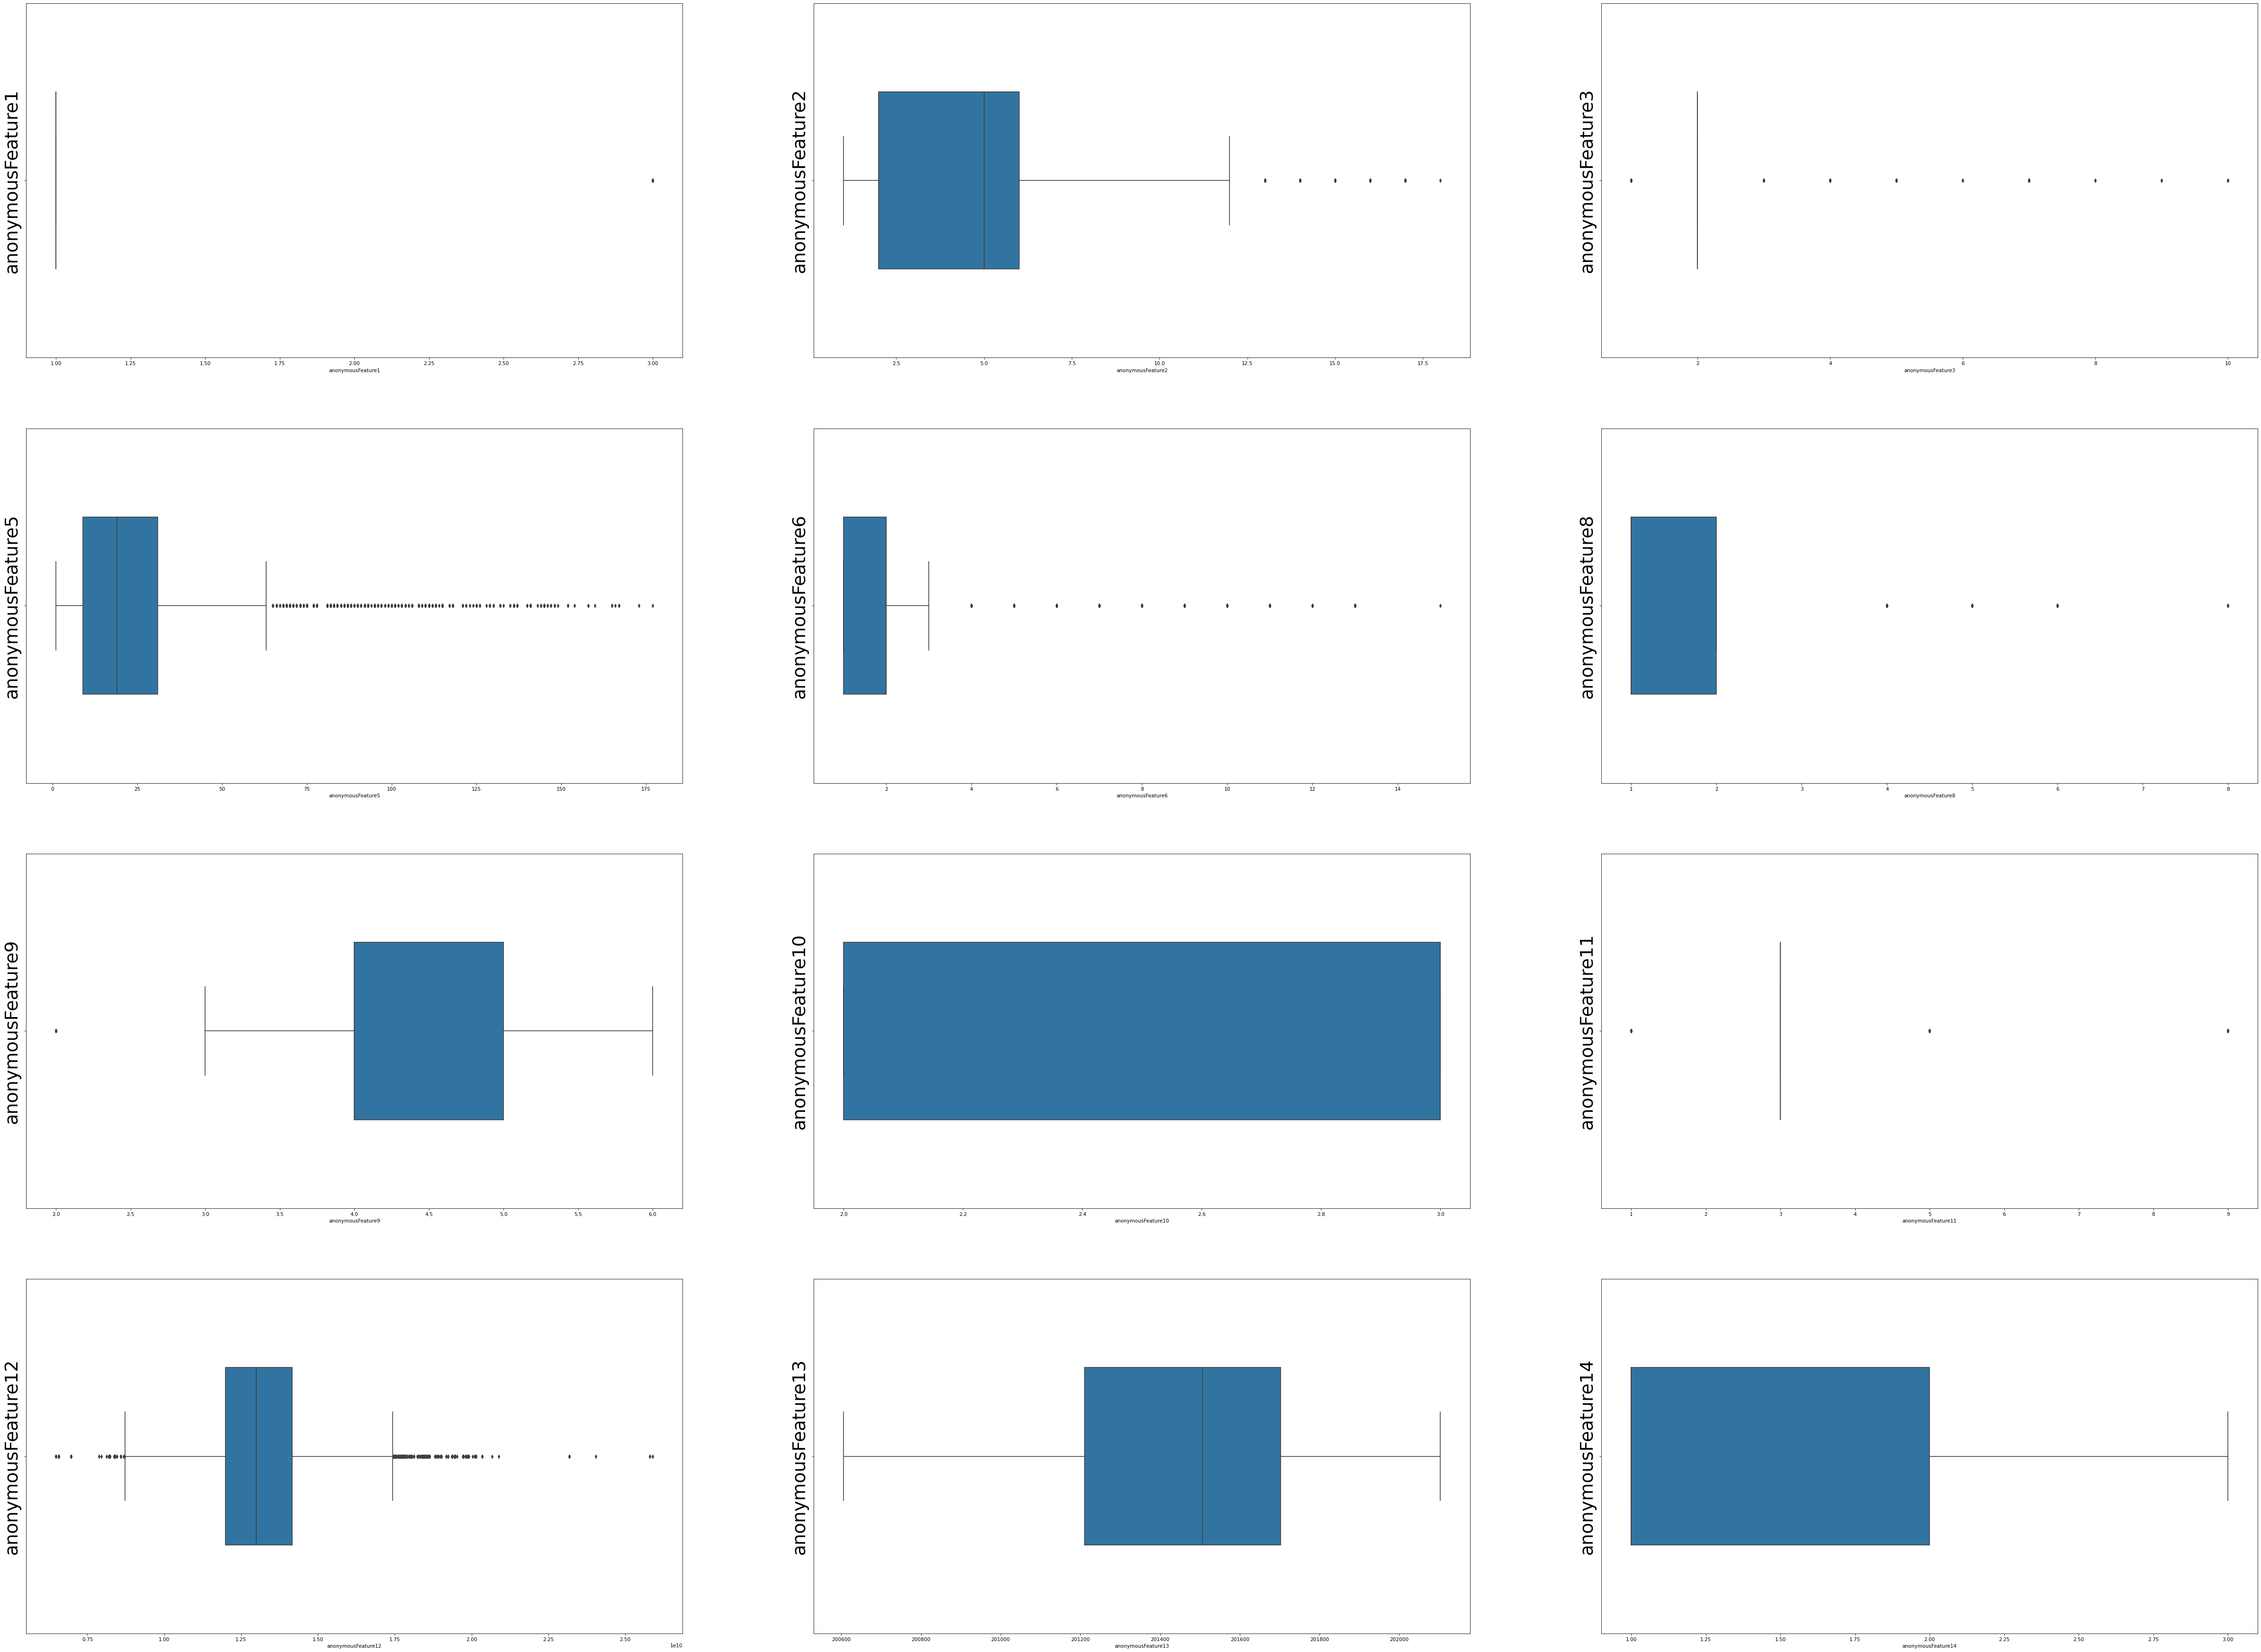

In [42]:
# 异常值的处理
# print(len(df_train.columns))

columns=[]
for i in range(1,15):
    columns.append('anonymousFeature'+str(i))
print(columns)
columns.remove('anonymousFeature4')
columns.remove('anonymousFeature7')
fig = plt.figure(figsize=(80,60),dpi=76)
for i in range(12):
    plt.subplot(4,3,i+1)
    sns.boxplot(df_train[columns[i]],orient='v',width=0.5)
    plt.ylabel(columns[i],fontsize=36)
plt.savefig('1.png')
plt.show()

In [ ]:
# 异常值的处理
# print(len(df_train.columns))

columns=['anonymousFeature1','anonymousFeature8','anonymousFeature9','anonymousFeature10']
fig = plt.figure(figsize=(80,60),dpi=76)
for i in range(4):
    plt.subplot(2,2,i+1)
    sns.boxplot(df_train[columns[i]],orient='v',width=0.5)
    plt.ylabel(columns[i],fontsize=36)
plt.savefig('1.png')
plt.show()

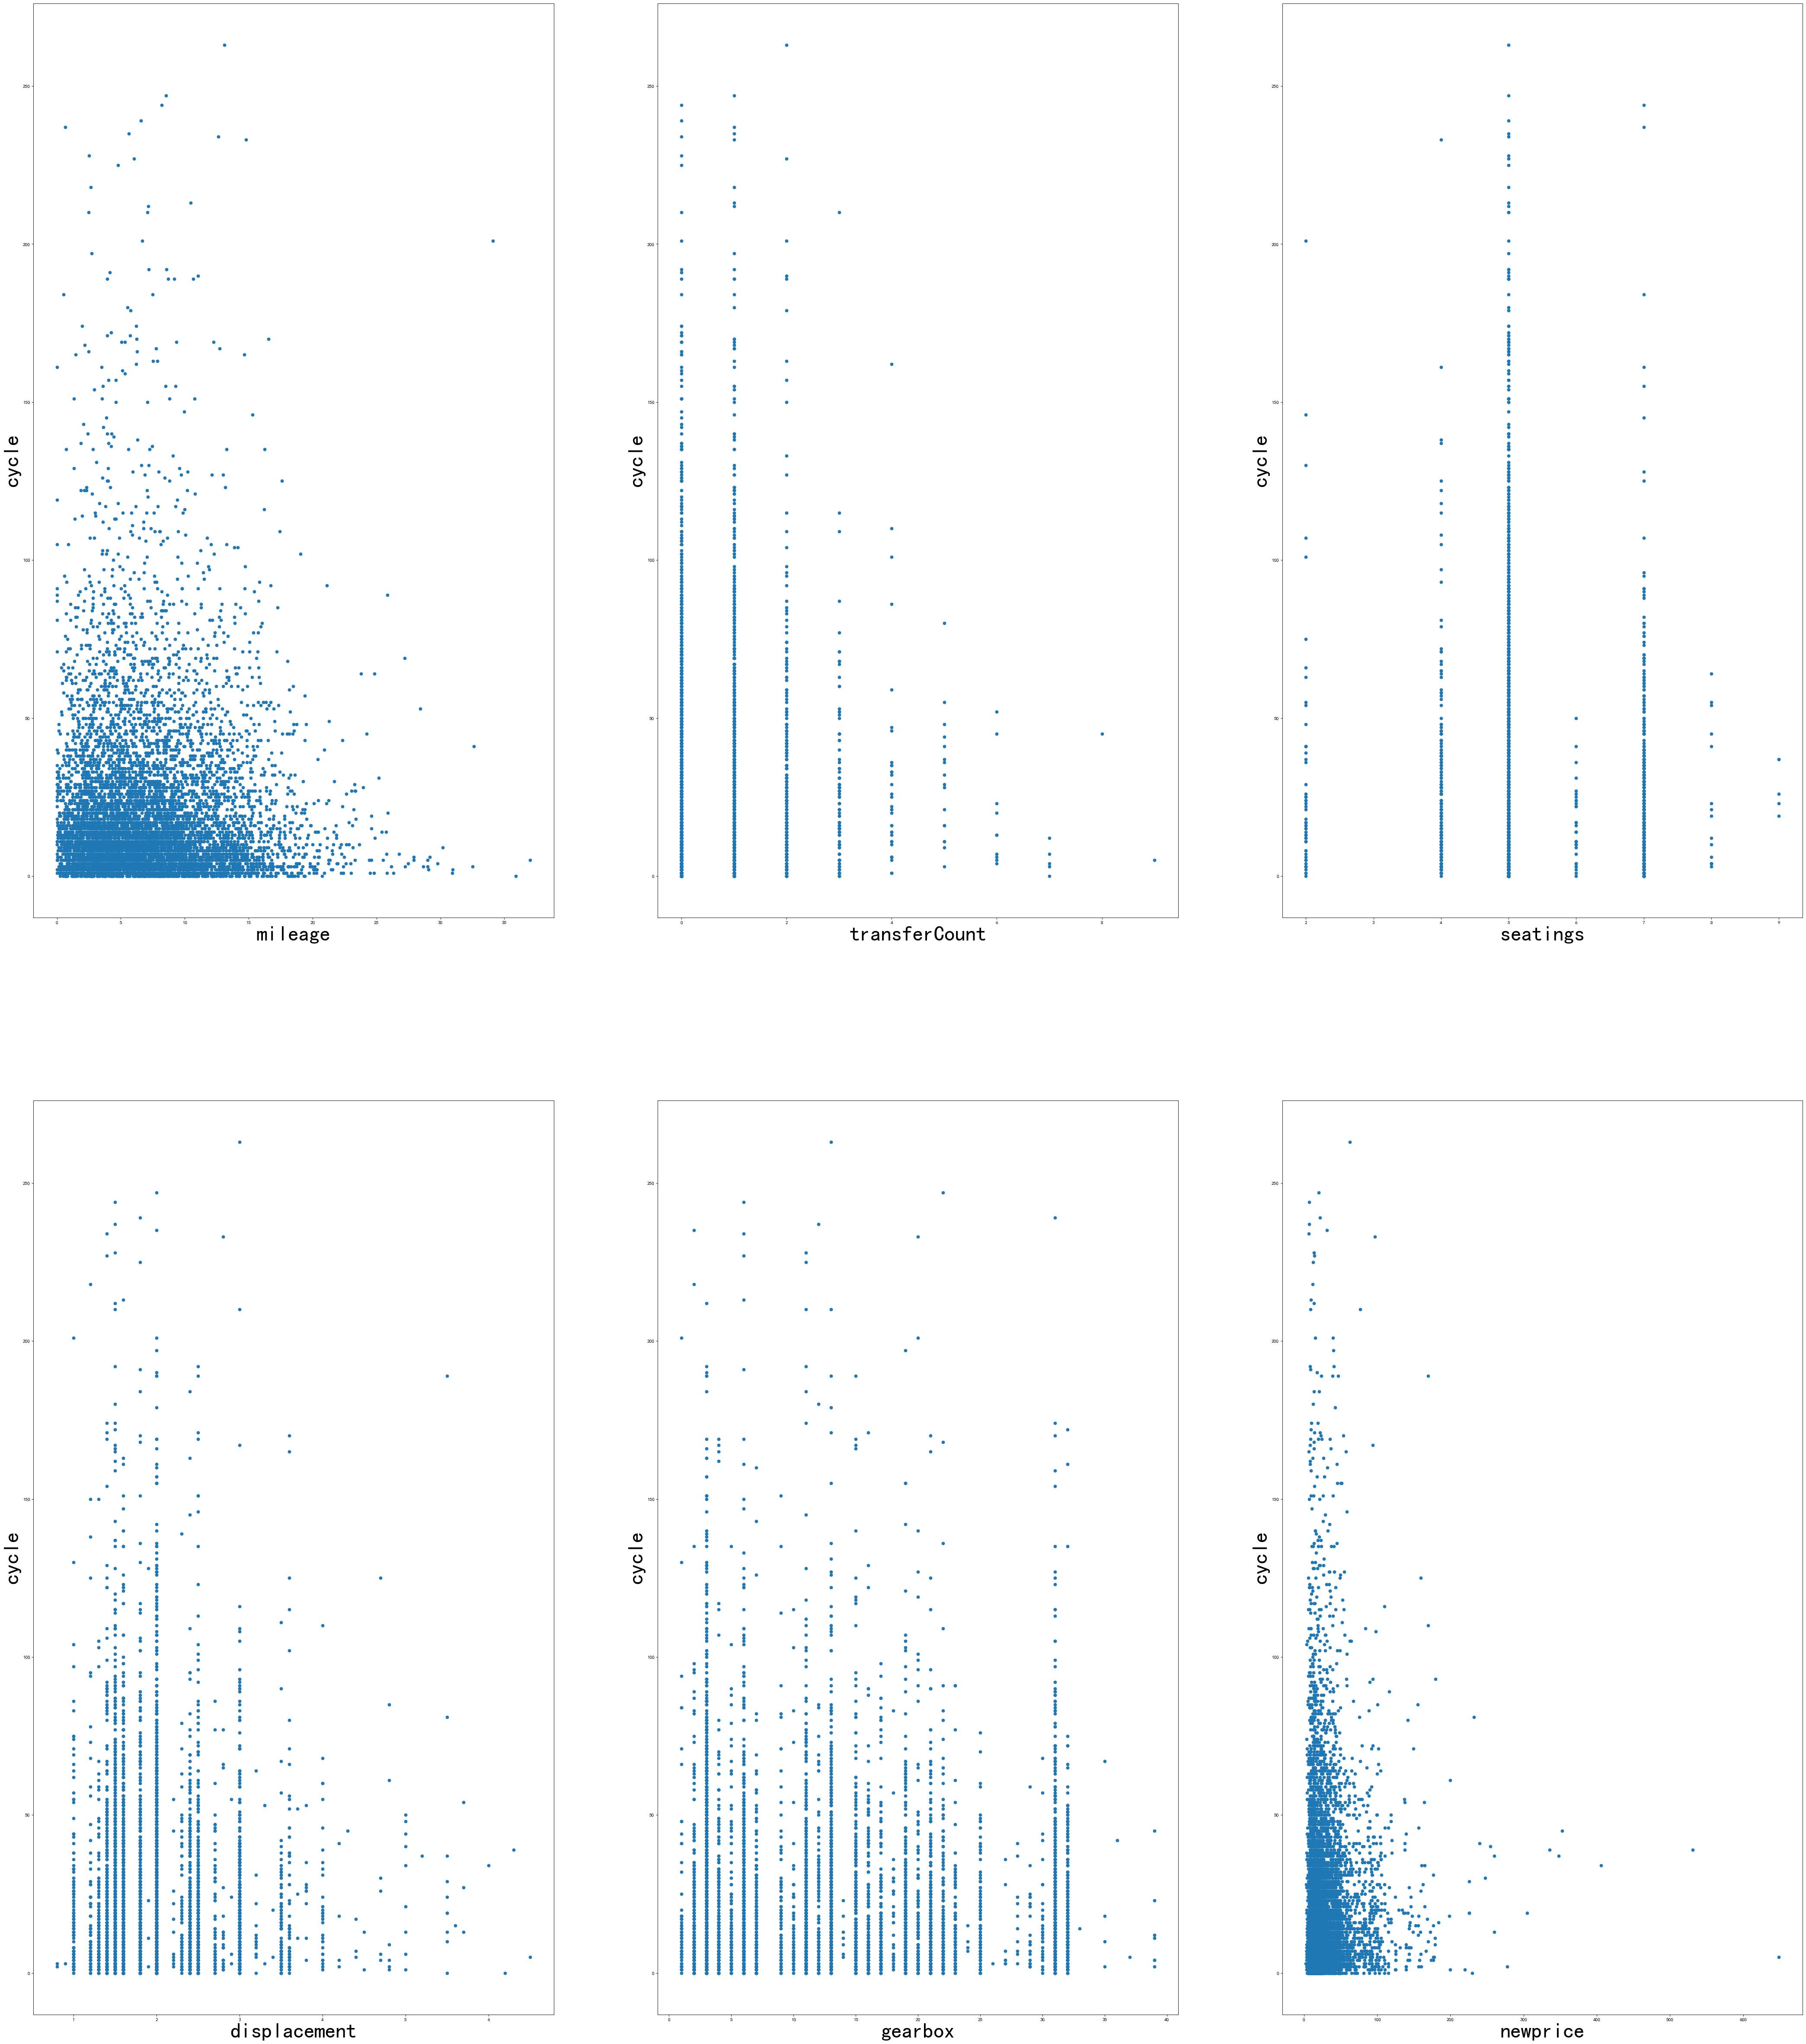

In [31]:
# 依然是上面的这些变量，不过，这次进行散点图的观察
nn=['mileage','transferCount','seatings','displacement','gearbox','newprice']
fig=plt.figure(figsize=(66,77),dpi=80)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.scatter(df_train[nn[i]],df_train['cycle'])
    plt.xlabel(nn[i],fontsize=44)
    plt.ylabel('cycle',fontsize=44)
plt.savefig('6.jpg')
plt.show()



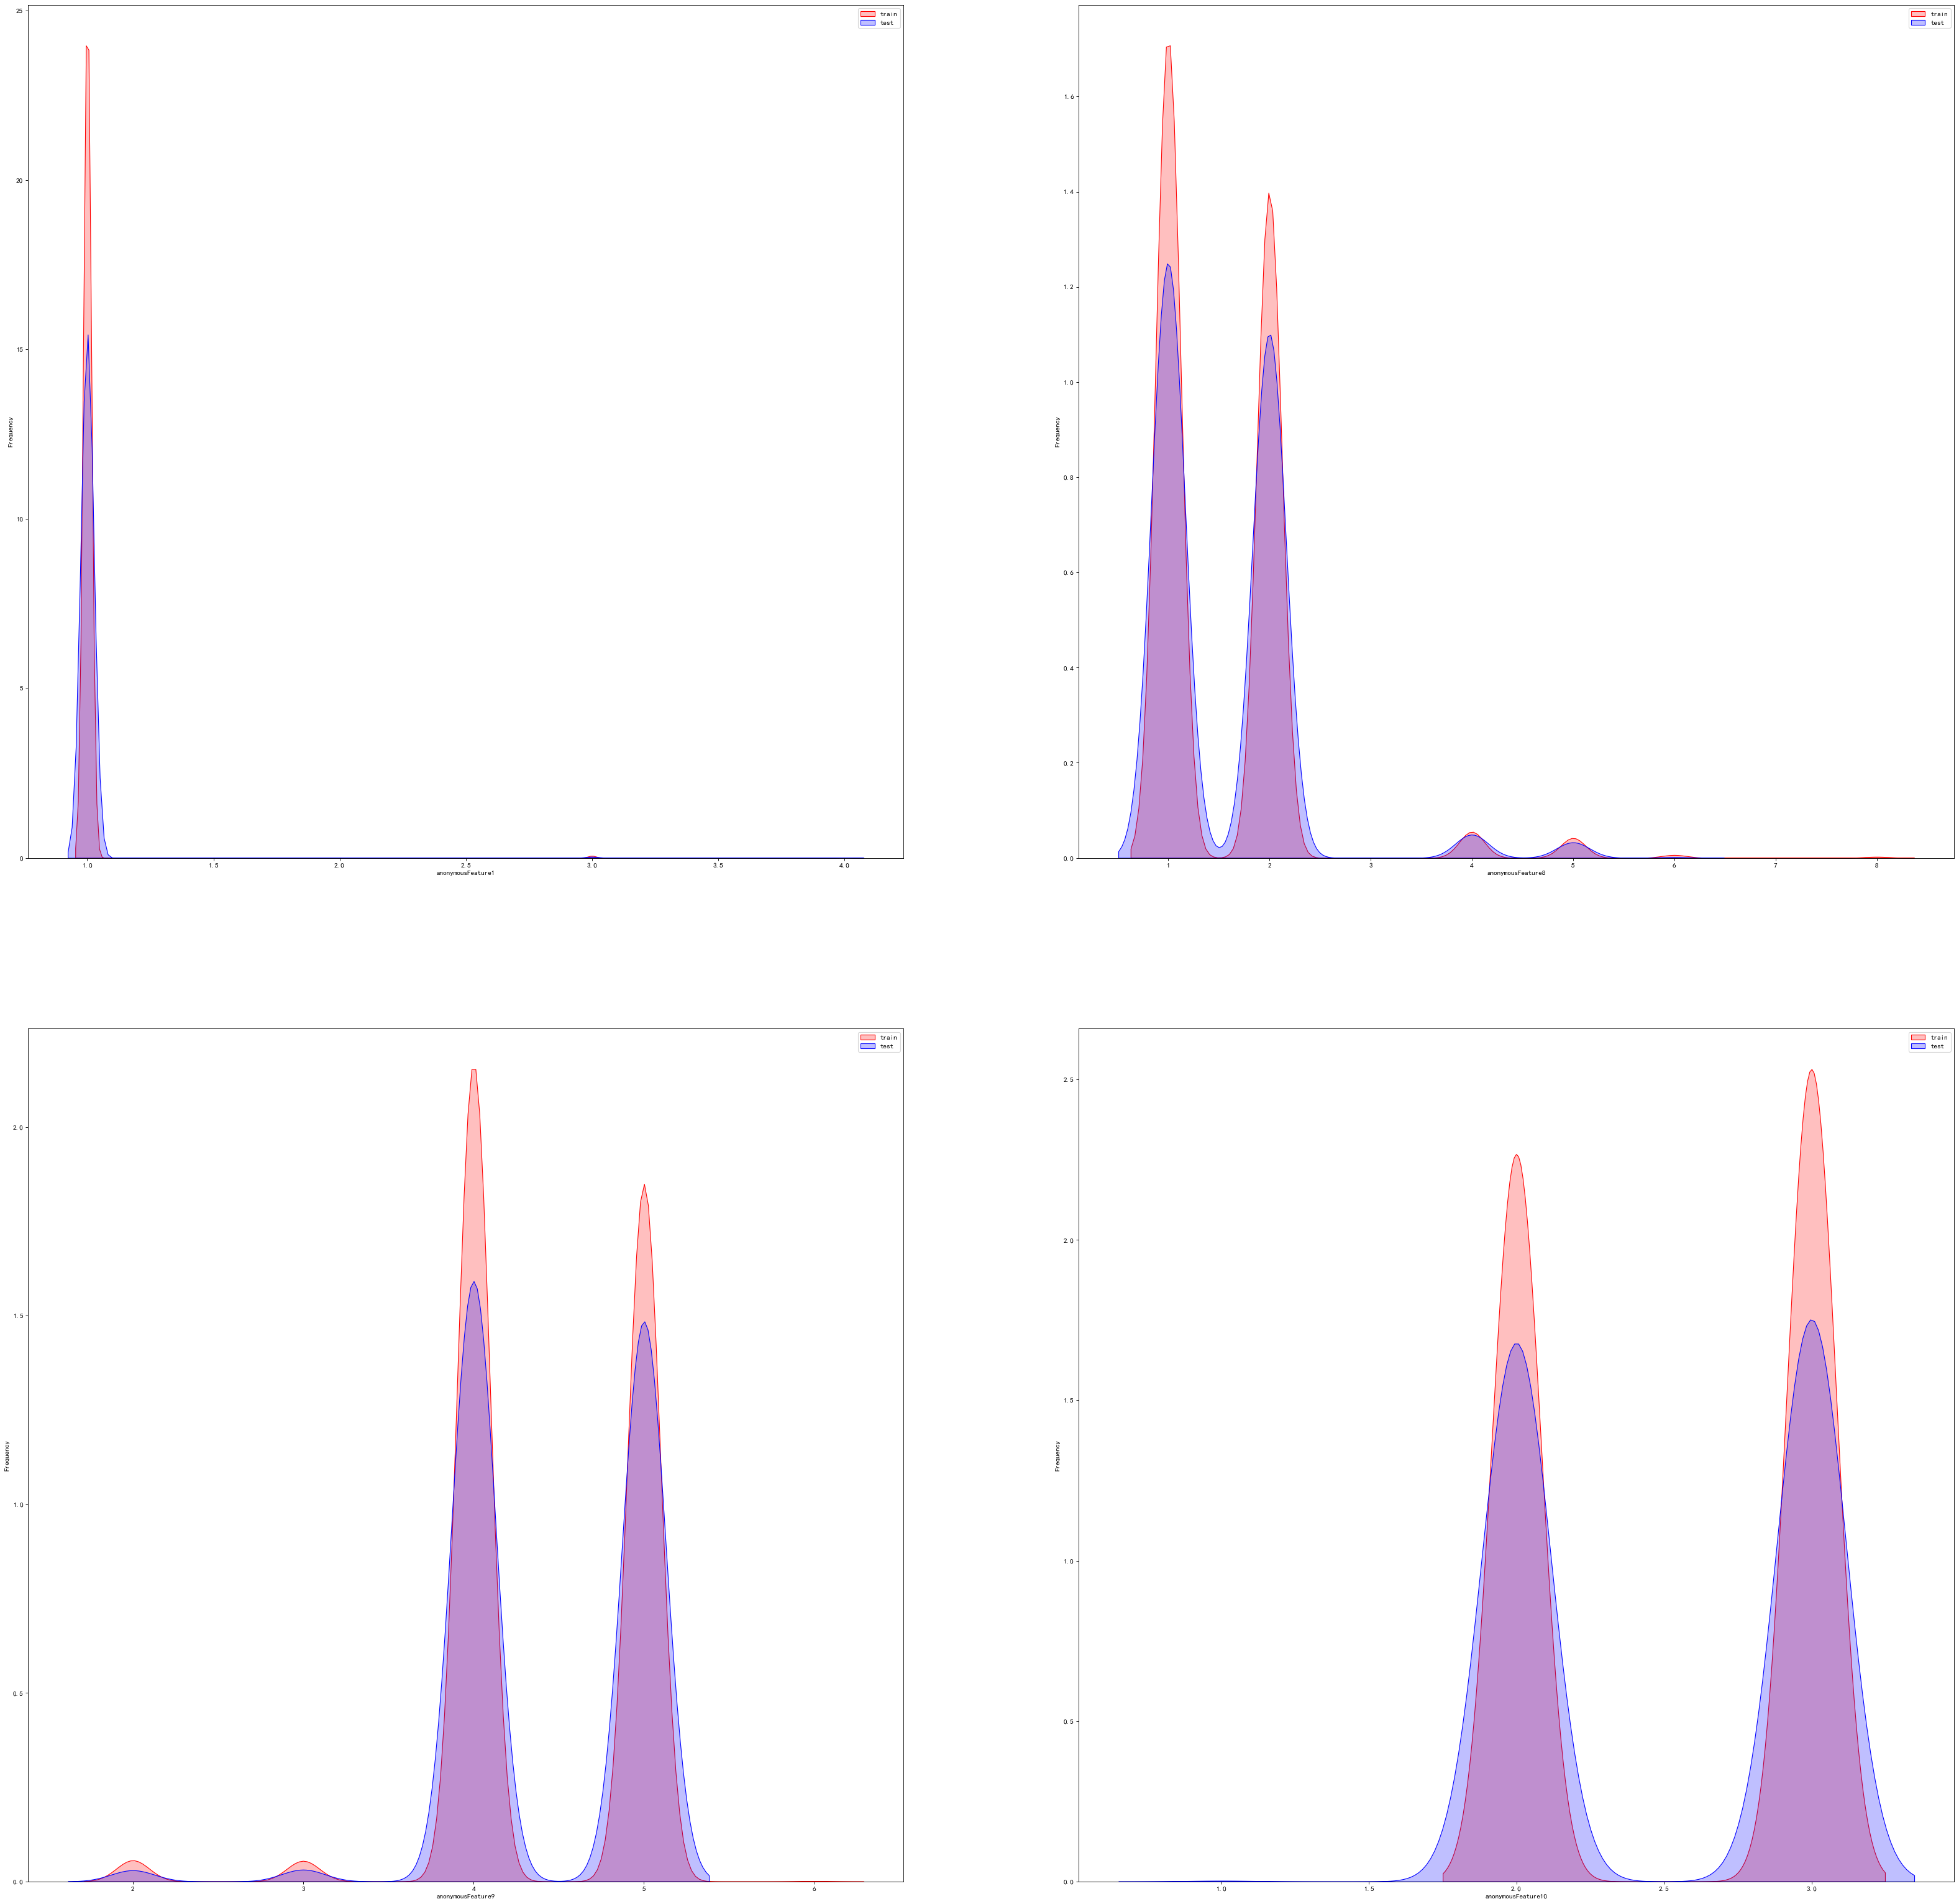

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei']  # 替换sans-serif字体
plt.rcParams['axes.unicode_minus'] = False  # 解决坐标轴负数的负号显示问题

columns=['anonymousFeature1','anonymousFeature8','anonymousFeature9','anonymousFeature10']
plt.figure(figsize=(50,50),dpi=80)
for i in range(4):
    ax=plt.subplot(2,2,i+1)
    ax=sns.kdeplot(df_train[columns[i]],color='red',shade=True)
    ax=sns.kdeplot(df_test[columns[i]],color='Blue',shade=True)
    ax.set_xlabel(columns[i])
    ax.set_ylabel('Frequency')
    ax=ax.legend(['train','test'])
# plt.title('匿名变量1,8,9,10在训练集和数据集的分布情况')
plt.savefig('3.png')
plt.show()